# Stability

Trying to understand why when we use noise we get a growth rate of $\gamma \simeq 0.11$, but when we use either of our other (Willis/single mode) ICs $\gamma \simeq 0.08$. 

In [1]:
import numpy as np
from dedalus import public as de
from eigentools import Eigenproblem, CriticalFinder
import matplotlib.pyplot as plt

In [2]:
plt.style.use('prl')

Use the parameters we've been using as a test, with $\alpha = 2\pi/\Gamma$ (the $k_z$ mode), with $\Gamma = 3$. 

In [3]:
nr = 32

# Marcus 1984b m=6 run
Re1 = 243.81
eta = 0.875
mu = 0.
Gamma = 3
alpha = 2*np.pi/Gamma
m = 0

In [4]:
"""
delta = R2 - R1
mu = Omega2/Omega1
eta = R1/R2

scale [L] = delta
scale [T] = delta/(R1 Omega1)
scale [V] = R1 Omega1
"""
#derived parameters
R1 = eta/(1. - eta)
R2 = 1./(1-eta)
nu = 1./Re1

variables = ['u','ur','v','vr','w','wr','p']

#domain
r_basis = de.Chebyshev('r', nr, interval=[R1, R2])

bases = [r_basis]
domain = de.Domain(bases) 

#problem
problem = de.EVP(domain, eigenvalue='sigma', variables=variables)

#params into equations
problem.parameters['eta']=eta
problem.parameters['mu']=mu
problem.parameters['nu']=nu
problem.parameters['kz'] = alpha
problem.parameters['m'] = m

#Substitutions

"""
this implements the cylindrical del operators. 
NB: ASSUMES THE EQUATION SET IS PREMULTIPLIED BY A POWER OF r (SEE BELOW)!!!

Lap_s --> scalar laplacian
Lap_r --> r component of vector laplacian
Lap_t --> theta component of vector laplacian
Lap_z --> z component of vector laplacian

"""

problem.substitutions['A'] = '(1/eta - 1.)*(mu-eta**2)/(1-eta**2)'
problem.substitutions['B'] = 'eta*(1-mu)/((1-eta)*(1-eta**2))'

problem.substitutions['v0'] = 'A*r + B/r'       #background profile? forcing instead of forcing the boundaries
problem.substitutions['dv0dr'] = 'A - B/(r*r)'  #d/dr of background forcing

problem.substitutions['dtheta(f)'] = '1j*m*f'
problem.substitutions['dz(f)'] = '1j*kz*f'
problem.substitutions['dt(f)'] = 'sigma*f'

# assume pre-multiplication by r*r
problem.substitutions['Lap_s(f, f_r)'] = "r*r*dr(f_r) + r*f_r + dtheta(dtheta(f)) + r*r*dz(dz(f))"
problem.substitutions['Lap_r'] = "Lap_s(u, ur) - u - 2*dtheta(v)"
problem.substitutions['Lap_t'] = "Lap_s(v, vr) - v + 2*dtheta(u)"
problem.substitutions['Lap_z'] = "Lap_s(w, wr)"

# momentum equations
problem.add_equation("r*r*dt(u) - nu*Lap_r - 2*r*v0*v + r*v0*dtheta(u) + r*r*dr(p) = 0")
problem.add_equation("r*r*dt(v) - nu*Lap_t + r*r*dv0dr*u + r*v0*u + r*v0*dtheta(v) + r*dtheta(p)  = 0")
problem.add_equation("r*r*dt(w) - nu*Lap_z + r*r*dz(p) + r*v0*dtheta(w) = 0.")

#continuity
problem.add_equation("r*ur + u + dtheta(v) + r*dz(w) = 0")

#Auxillilary equations
problem.add_equation("ur - dr(u) = 0")
problem.add_equation("vr - dr(v) = 0")
problem.add_equation("wr - dr(w) = 0")

#Boundary Conditions
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(w) = 0")


ep = Eigenproblem(problem)

2022-04-19 22:01:00,794 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2022-04-19 22:01:00,949 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


And we note that the growth rate is $\gamma = 0.0786$, which agrees to two digits with both of our ICs $\gamma_{willis} = 0.078647$, $\gamma_{1 mode} = 0.078122$.

In [5]:
ep.solve(sparse=False)

In [6]:

ep.evalues_good.real.max()

0.07867034136913711

So what's wrong with the noise ICs? Nothing: it's just that the $\alpha = 2 \pi/3$ is not the fastest growing mode in this domain.

In [7]:
cf = CriticalFinder(ep, ("kz","m"), find_freq=False)
nx = 10
ny = 10
xpoints = alpha*np.linspace(1, 10, nx)
ypoints = np.linspace(0,10,ny,endpoint=False)

In [8]:
cf.load_grid('TC_Re243.81_eta0.875_grid.h5')

2022-04-19 22:01:02,861 criticalfinder 0/1 INFO :: Read an 2-dimensional grid


/home/joishi/vc/eigentools/eigentools/criticalfinder.py:323: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = pax.pcolormesh(xx,yy,grid,cmap=cmap,vmin=-biggest_val,vmax=biggest_val)


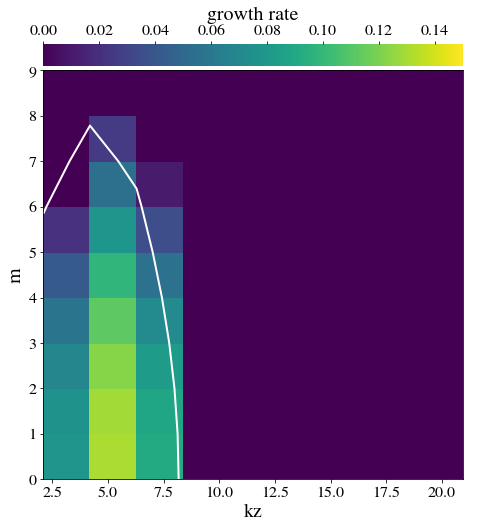

In [9]:
pax,cax = cf.plot_crit()
pax.collections[0].set_clim(0,0.15)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')
pax.contour(cf.parameter_grids[0], cf.parameter_grids[1],cf.evalue_grid.real, levels=(0,), colors='white')
pax.figure.savefig('TC_Re243.81_eta0.875_growth_rates.png',dpi=300)

Looking at the only $k_z$ in the unstable region, we see that in fact $k_z/\alpha = 2$ is the fastest growing mode for this $L_z = 3$.

Text(0, 0.5, 'growth rate')

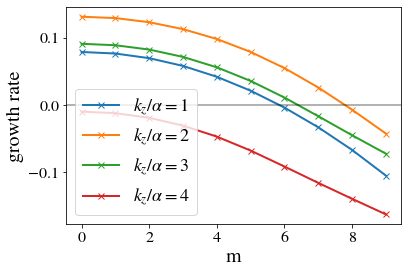

In [10]:
plt.plot(cf.evalue_grid[:,0].real,'x-', label=r'$k_z/\alpha = 1$')
plt.plot(cf.evalue_grid[:,1].real,'x-', label=r'$k_z/\alpha = 2$')
plt.plot(cf.evalue_grid[:,2].real,'x-', label=r'$k_z/\alpha = 3$')
plt.plot(cf.evalue_grid[:,3].real,'x-', label=r'$k_z/\alpha = 4$')

plt.legend()
plt.axhline(0, color='k',alpha=0.3)
plt.xlabel("m")
plt.ylabel("growth rate")

In [11]:
max_loc = cf.evalue_grid.real.argmax()
ind = np.unravel_index(max_loc, cf.evalue_grid.shape)
kz = cf.parameter_grids[0][ind]
m = cf.parameter_grids[1][ind]
print("maximum growth rate {:5.2e} at (m, kz/alpha) = ({:5d},{:5.2f})".format(cf.evalue_grid[ind].real, int(m),kz/alpha))

maximum growth rate 1.31e-01 at (m, kz/alpha) = (    0, 2.00)


But the question is now why is our noise IC $\gamma_{noise} = 0.113635 < 0.131$. Probably timestepping? Should check this.

## Pseudospectra

In [12]:
def energy_norm(Q1, Q2):
    u1 = Q1['u']
    v1 = Q1['v']
    w1 = Q1['w']
    u2 = Q2['u']
    v2 = Q2['v']
    w2 = Q2['w']

    field = (np.conj(u1)*u2 + np.conj(v1)*v2 + np.conj(w1)*w2).evaluate().integrate()
    return field['g'][0]

In [13]:
k = 25

psize = 100
ps_real = np.linspace(-1,1,psize)
ps_imag = np.linspace(-1,1,psize)

In [14]:
ep.calc_ps(k, (ps_real, ps_imag), inner_product=energy_norm,maxiter=30)

In [15]:
clevels = np.linspace(-1.8,0, 7)

Text(0, 0.5, '$\\omega$')

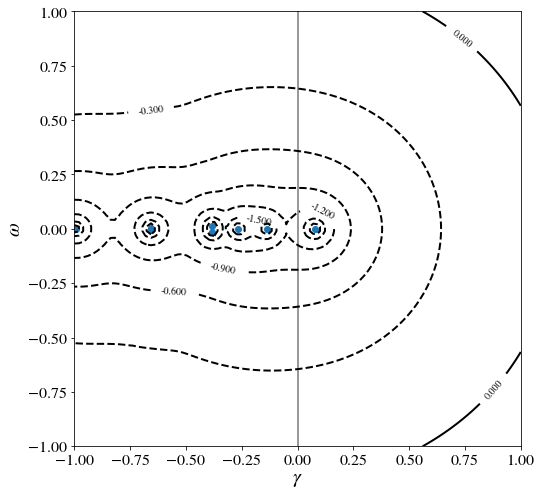

In [16]:
plt.figure(figsize=(8,8))
plt.scatter(ep.evalues_good.real, ep.evalues_good.imag)
plt.axvline(0, color='k', alpha=0.4)
CS = plt.contour(ep.ps_real, ep.ps_imag, np.log10(ep.pseudospectrum),levels=clevels,colors='k')
plt.xlim(-1,1)
plt.ylim(-1,1)
#ax.scatter()
plt.clabel(CS, inline=True, fontsize=10)
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\omega$")

In [17]:
ps_max = np.log10(ep.pseudospectrum).max()